Taking inspiration from http://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/,
trying to do some image analysis on the instagram posts I collected.

There's a handy library at https://github.com/neocortex/paletti/blob/master/paletti/paletti.py that uses different ways of calculating the palette. I'll just try using the kmeans with scikitlearn method for now

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import pymongo
from pymongo import MongoClient
client = MongoClient()

In [2]:
from sklearn.cluster import KMeans
from skimage import io, color

In [ ]:
import colorsys

In [3]:
from pprint import pprint
from collections import namedtuple

again, for illustration, what one data entry looks like on the db

In [ ]:
db = client['instagram-london']
coll = db.posts
# cursor = coll.find().sort('created_time', pymongo.DESCENDING).limit(1)
# for i in cursor:
#     pprint(i)

In [120]:
# response = requests.get('https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/14240783_286379521748291_1428124432_n.jpg?ig_cache_key=MTM0MTU1Mzg2MDIyOTQxNjMwMw%3D%3D.2.l')
#to test out the algorithm, I used an image that has clear colors:
response = requests.get('https://upload.wikimedia.org/wikipedia/en/e/e7/Jurassic_Park_poster.jpg')
imgIO = BytesIO(response.content)
origimg = Image.open(imgIO)

In [122]:
#resize the image to a smaller one for faster analysis
origimg.thumbnail((200, 200), Image.ANTIALIAS)

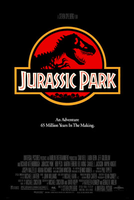

In [123]:
#this is the shrunk image
origimg

In [160]:
w, h, d = np.asarray(origimg).shape
print(w, h, d)

200 134 3


In [142]:
#convert the img to a 2D array for kmeans
imarr = np.reshape(np.array(origimg), (w * h, d)).astype('float64') #have to convert the origimg which is in unit8 to float64
# Perform k-means clustering
kmeans = KMeans(n_clusters=5).fit(imarr)
#and also get the labels for each pixel for the corresponding cluster
labels = kmeans.predict(imarr)

In [144]:
#the 5 color palette
maincolors = kmeans.cluster_centers_
maincolors

array([[   1.60301928,    1.16556845,    1.2202498 ],
       [ 235.35933504,  214.97953964,  199.83503836],
       [ 203.32077295,  147.07439614,   69.83091787],
       [ 220.0303757 ,    1.44044764,    2.29896083],
       [  49.51295642,   40.43580683,   37.41578327]])

In [153]:
cluster_img = np.zeros(imarr.shape, dtype='float')
for i, lab in enumerate(labels):
    cluster_img[i] = maincolors[lab]
    #cluster_img[i] = mainColorsRGB[lab]
    # Compute percentage of each main color
percent, _ = np.histogram(labels, bins=len( maincolors), normed=True)
percent /= float(percent.sum())

In [146]:
percent

array([ 0.75869403,  0.0291791 ,  0.03865672,  0.0466791 ,  0.12679104])

In [147]:
newImg = (np.reshape(cluster_img, (w, h, 3))).astype(
            'uint8')

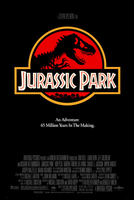

In [124]:
Image.fromarray(np.array(origimg))

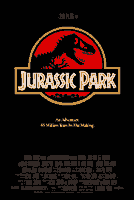

In [154]:
#and here is the reconstructed image=> not too far off
Image.fromarray(newImg)

In [180]:
Palette = namedtuple('Palette', 'colors percent')
def kmeans_palette(fname, k=5, RSIZE=200):
    """ Extract a color palette using k-means clustering. """
    origimg = Image.open(fname)
    origimg.thumbnail((RSIZE, RSIZE), Image.ANTIALIAS)
    img = np.array(origimg)
    w, h, d = img.shape
    imarr = np.reshape(img, (w * h, d)).astype('float64')
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k).fit(imarr)
    labels = kmeans.predict(imarr)
    maincolors = kmeans.cluster_centers_

    # Compute percentage of each main color
    percent, _ = np.histogram(labels, bins=len(maincolors), normed=True)
    percent /= float(percent.sum())
    
    cluster_img = np.zeros(imarr.shape, dtype='float')
    for i, lab in enumerate(labels):
        cluster_img[i] = maincolors[lab]
    clustedImageArr = (np.reshape(cluster_img, (w, h, 3))).astype('uint8')
    return Palette(maincolors.squeeze(), percent), clustedImageArr

In [181]:
#now lets try it on the actual photo
palette, clusteredImg = kmeans_palette(BytesIO(requests.get('https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/14240783_286379521748291_1428124432_n.jpg?ig_cache_key=MTM0MTU1Mzg2MDIyOTQxNjMwMw%3D%3D.2.l')
               .content))

In [182]:
palette

Palette(colors=array([[ 252.9394557 ,  252.93741758,  253.05574871],
       [  23.1250229 ,   22.63125114,   18.19335043],
       [ 186.05127159,  175.33904529,  175.89800082],
       [  77.27898984,   71.52570233,   65.3559474 ],
       [ 138.56481481,  124.36514337,  116.90456989]]), percent=array([ 0.2085  ,  0.272825,  0.182825,  0.167775,  0.168075]))

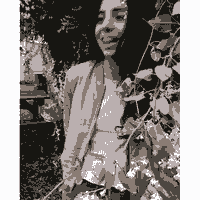

In [183]:
Image.fromarray(clusteredImg)

In [184]:
#hmm, sort of works, but leave much to be desired...?

palette2, clusted2 = kmeans_palette(BytesIO(requests.get('https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/14310858_102844706843355_1629864440_n.jpg?ig_cache_key=MTMzNzU2OTQ2OTA5ODk2NjMzMw%3D%3D.2').content))

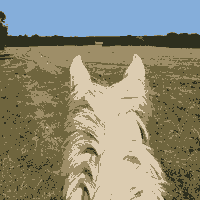

In [185]:
Image.fromarray(clusted2)

In [186]:
#okay, tweaking the kmeans so it takes in an url by default
def kmeans_palette_from_url(url, k=5, RSIZE=200):
    """ Extract a color palette using k-means clustering. """
    imgIO = BytesIO(requests.get(url).content)
    origimg = Image.open(imgIO)
    origimg.thumbnail((RSIZE, RSIZE), Image.ANTIALIAS)
    img = np.array(origimg)
    w, h, d = img.shape
    imarr = np.reshape(img, (w * h, d)).astype('float64')
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k).fit(imarr)
    labels = kmeans.predict(imarr)
    maincolors = kmeans.cluster_centers_

    # Compute percentage of each main color
    percent, _ = np.histogram(labels, bins=len(maincolors), normed=True)
    percent /= float(percent.sum())
    
    cluster_img = np.zeros(imarr.shape, dtype='float')
    for i, lab in enumerate(labels):
        cluster_img[i] = maincolors[lab]
    clustedImageArr = (np.reshape(cluster_img, (w, h, 3))).astype('uint8')
    return Palette(maincolors.squeeze(), percent), clustedImageArr

In [187]:
palette3, clustered3 = kmeans_palette_from_url('https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/14334265_1068230916623681_1151948613_n.jpg?ig_cache_key=MTMzNzYxMTIyNjE5NjY3NTI4Mw%3D%3D.2')

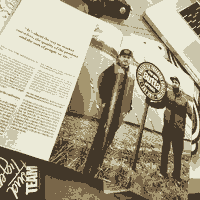

In [188]:
Image.fromarray(clustered3)

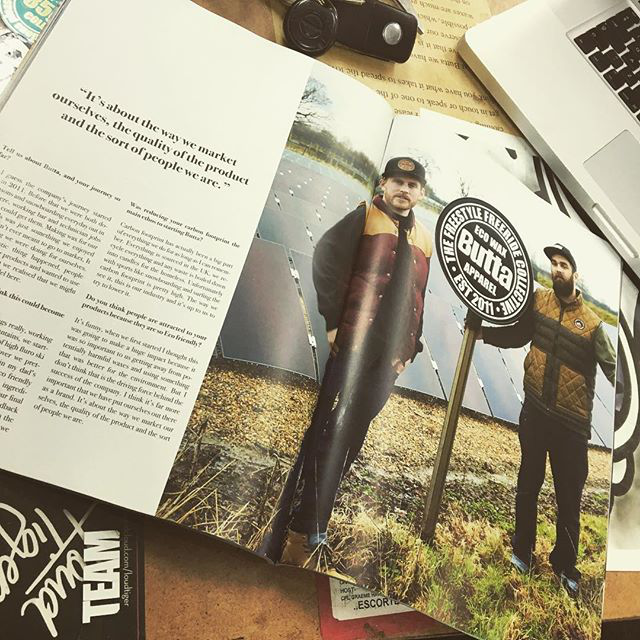

In [189]:
Image.open(BytesIO(requests.get('https://scontent.cdninstagram.com/t51.2885-15/s640x640/sh0.08/e35/14334265_1068230916623681_1151948613_n.jpg?ig_cache_key=MTMzNzYxMTIyNjE5NjY3NTI4Mw%3D%3D.2').content))

In [2]:
#it might be interesting to do plots of variation in lightness and hue etc, so 
rd, gn, bl = 203.32077295,  147.07439614,   69.83091787
h,s,v = colorsys.rgb_to_hsv(rd/255.,gn/255.,bl/255.)
print(h)
print(s)
print(v)

0.09644113432653523
0.6565480405331107
0.7973363645098039


In [ ]:
#so an idea to try is to get the hsv values of all domainant colors from each image and 